# Ising 1D transverse field model
## Ground state energy, magnetization and susceptibility

### Libraries

In [1]:
using Printf
using SparseArrays
using ArnoldiMethod # For solving eigenvalue problems with sparse matrices
using Plots
using QuadGK # For numerical integration
using Random

### Functions

In [2]:
# Redefinition of tensor product
function ⊙(x,y)
    kron(x,y)
end

# Sparse Hamiltonian
function buildHamiltonian_sparse(;N,J,B)
    #  Input: -----------------------------
    #
    #  N: Number of spins in the chain
    #
    #  J: Hamiltonian interaction term
    #
    #  B: Transverse magnetic field
    #  term
    #
    #  Output: ----------------------------
    #
    #  H: Hamiltonian matrix projected
    #  onto spin basis
    
    Id = [[1,0] [0,1]] |> sparse
    σᶻ = [[1,0] [0,-1]] |> sparse
    σˣ = [[0,1] [1,0]] |> sparse
    
    # Coupling term
    first_term = fill(Id,N)
    first_term[1] = σᶻ
    first_term[2] = σᶻ
    
    second_term = fill(Id,N)
    second_term[1] = σˣ
    
    # Initialize sparse zero matrix
    H = spzeros(Int,2^N,2^N)
    for i in 1:N
        H += -J*foldl(⊙, first_term) -B*foldl(⊙, second_term)
        first_term = circshift(first_term,1)
        second_term = circshift(second_term,1)
    end
    return H
end

# Sparse eigenvalues
function eigen_sparse(x)
    decomp, history = partialschur(x, nev=1, which=:SR); # only solve for the ground state
    vals, vecs = partialeigen(decomp);
    return vals, vecs
end

# Magnetization of a given state
function buildMagnetizations_sparse(state;N)
    # Input: ------------------------------
    #
    # state: column vector or matrix of vectors
    # encoding a projected wavestate onto the
    # spin basis of the Ising model
    #
    # N: Number of spins in the chain
    # 
    # Output: -----------------------------
    #
    # st_mz: value of the longitudinal
    # magnetization
    #
    # st_mx: value of the transversal
    # magnetization
    
    Id = [[1,0] [0,1]] |> sparse
    σᶻ = [[1,0] [0,-1]] |> sparse
    σˣ = [[0,1] [1,0]] |> sparse
    
    mz = fill(Id,N)
    mz[1] = σᶻ
    
    mx = fill(Id,N)
    mx[1] = σˣ
    
    # Build magnetizations
    Mz = spzeros(Int,2^N,2^N)
    Mx = spzeros(Int,2^N,2^N)
    for i in 1:N
        Mz += foldl(⊙, mz)/N
        Mx += foldl(⊙, mx)/N
        mz = circshift(mz, 1)
        mx = circshift(mx, 1)
    end
    
    # Calculate magnetization of the state
    st_mz = sqrt(state'*Mz^2*state)
    st_mx = sqrt(state'*Mx^2*state)
    
    return st_mz, st_mx
end

# Magnetization in the thermodynamic limit (integral)
function magnetizationIntegral(;J,B)
    # Input: -----------------------------
    #
    # J: Hamiltonian interaction term
    #
    # B: Transverse magnetic field term
    #
    # Output: ----------------------------
    #
    # in_mz: value of the longitudinal
    # magnetization in the thermodynamic limit
    #
    # in_mx: value of the transversal
    # magnetization in the thermodynamic limit
    
    in_mz = (B < J) ? (1 - B^2/J^2)^(1/8) : 0
    
    in_mx, err = quadgk(k -> (B + J*cos(k))/sqrt(J^2 + B^2 + 2*J*B*cos(k)), 
        0, pi, rtol=1e-10)
    
    return in_mz, in_mx/pi
end

magnetizationIntegral (generic function with 1 method)

### RBM Class

In [ ]:
# RBM wavefunction class
mutable struct RBM
    n_visible::Int
    n_hidden::Int
    params::Vector{Complex64}
    
    function RBM(n_visible::Int, n_hidden::Int)
        rbm = new(n_visible, n_hidden, ComplexF64[])
        initialise_rbm(rbm)
        return RBM
    end
end

# Initialize RBM wavefunction
function initialise_RBM(rbm::RBM;σ=0.01)
    # Parameters of the RBM can be complex valued,
    # and are initialized from a random distribution
    b = randn(ComplexF64,rbm.n_visible)
    c = randn(ComplexF64,rbm.n_hidden)
    W = randn(ComplexF64,rbm.n_hidden,rbm.n_visible)
    
    rbm.params = σ*vcat(b,c,reshape(W,:))
end

# Define property-like functions
function b(rbm::RBM)
    # Returns column vector of visible bias
    return rbm.params[1:rbm.n_visible]
end

function c(rbm::RBM)
    # Returns column vector of hidden bias
    nv = rbm.n_visible
    return rbm.params[nv+1 : nv+rbm.n_hidden]
end

function W(rbm::RBM)
    # Returns nh x nv weight matrix
    nv, nh = rbm.n_visible, rbm.n_hidden
    return reshape(rbm.params[nv+nh+1:end], nh, nv)
end
    
# Additional functions that may be useful
function p(rbm::RBM, s::Vector{ComplexF64})
    # Calculate wavefunction projection onto state s
    return exp(conj(b(rbm))' * s) * prod(cosh(c(rbm) .+ W(rbm) * s)) * 2^rbm.n_hidden
end

function p_ratio(rbm::RBM, s1::Vector{ComplexF64}, s2::Vector{ComplexF64})
    # Ratio of probabilities between states s2 and s1
    f1 = cosh.(c(rbm) .+ W(rbm) * s1)
    f2 = cosh.(c(rbm) .+ W(rbm) * s2)
    log_diff = conj(b(rbm))' * (s2 - s1) + sum(log.(f2 ./ f1))  # log of ratio for numerical stability
    return exp(log_diff)
end

function p_ratios(rbm::RBM, s1::Vector{ComplexF64}, s2::Vector{Vector{ComplexF64}})
    # Ratio of probabilities between list of states s2 and state s1
    return [p_ratio(rbm, s1, s) for s in s2]
end

## main

### Ground state and ground energy

Calculate the ground state energy given the number of spins $N$, the coupling interaction term $J$ and the strength of the transverse magnetic field $B$.

In [3]:
# Value of the coupling term and transverse magnetic field
J, B = 2, 1

# Number of spins
N = 2
H = buildHamiltonian_sparse(N=N,J=J,B=B)

ground_energy, ground_state = eigen_sparse(H)

@printf "Ground state energy: %.8f\n" ground_energy[1]
@printf "Ground state:\n"
display(ground_state)

Ground state energy: -4.47213595
Ground state:


4×1 Matrix{Float64}:
 -0.6881909602355865
 -0.16245984811645325
 -0.16245984811645325
 -0.688190960235587

### Ground state magnetization

Calculate the longitudinal and transversal magnetizations of the ground state.

In [4]:
st_mz, st_mx = buildMagnetizations_sparse(ground_state;N=N)

([0.9732489894677301;;], [1.0;;])

### Plot of the phase transition

We calculate the longitudinal magnetization of the ground state for different values of $B/J$ and plot it for many $N$:

100.209245 seconds (4.54 M allocations: 229.410 GiB, 9.45% gc time, 1.08% compilation time: 13% of which was recompilation)


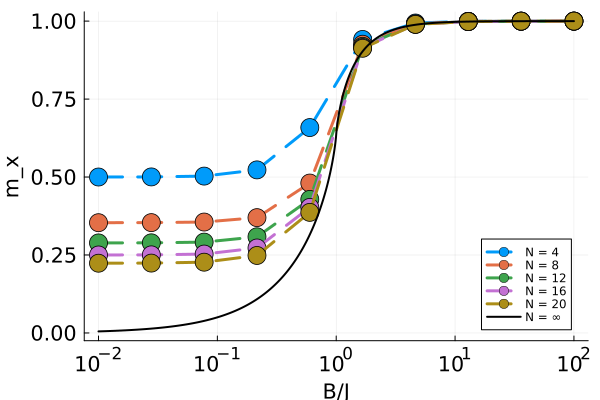

In [5]:
# Values of B/J
B_J = 10 .^ range(start=-2., stop=2., length=10)
Ns = 4:4:20

p = plot()
q = plot()
@time for N in Ns
    Mz = zeros(length(B_J))
    Mx = zeros(length(B_J))
    for (i,b) in enumerate(B_J)
        H = buildHamiltonian_sparse(N=N,J=1,B=b)
        vals, vecs = eigen_sparse(H)
        ground_state = @view vecs[:,1]
        Mz[i], Mx[i] = buildMagnetizations_sparse(ground_state,N=N)
    end
    plot!(p, B_J, Mz, marker=:circle, label="N = $N", xscale=:log10,
        lw=3, ls=:dash, markersize=6)
    plot!(q, B_J, Mx, marker=:circle, label="N = $N", xscale=:log10,
        lw=3, ls=:dash, markersize=6)
end

# Finer grid
B_J = 10 .^ range(start=-2., stop=2., length=1000)
in_mz = zeros(length(B_J))
in_mx = zeros(length(B_J))

for (i,b) in enumerate(B_J)
    # Add thermodynamic limit N → ∞
    in_mz[i], in_mx[i] = magnetizationIntegral(J=1,B=b)
end
plot!(p, B_J, in_mz, c=:black, label="N = ∞", lw=2, 
    xlab="B/J", ylab="m_z", xtickfontsize=14, xguidefontsize=14,
        ytickfontsize=14, yguidefontsize=14)
plot!(q, B_J, in_mx, c=:black, label="N = ∞", lw=2,
    xlab="B/J", ylab="m_x", xtickfontsize=14, xguidefontsize=14,
        ytickfontsize=14, yguidefontsize=14)

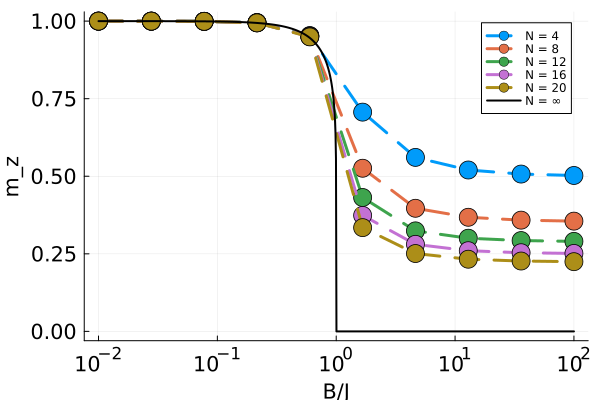

In [6]:
p